# SVM code

In [1]:
import numpy as np
import cvxopt

class SVM():
    def __init__(self, kernel='linear', C=0.001, gamma=0.001, degree=3):
        #parameters
        self.C = float(C)
        self.gamma = float(gamma)
        self.d = int(degree)
        
        if kernel == 'linear':
            self.kernel = self.linear
        elif kernel == 'polynomial':
            self.kernel = self.polynomial
        elif kernel == 'gaussian':
            self.kernel = self.gaussian
        else:
            raise NameError('Unknown')
            
    def linear(self, x1, x2):
        return(np.dot(x1, x2))
        
    def polynomial(self, x1, x2):
        return (np.dot(x1,x2)+1) ** self.d
    
    def gaussian(self, x1, x2):
        return np.exp(-self.gamma*np.linalg.norm(x1-x2) ** 2)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape 
        
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])
        
        #------Solve cuadratic problem
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C == 0:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.identity(n_samples) * -1
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
            
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        #-------------------------------------------------------------------------------------------------
        
        #extrct lagrange multipliers
        lamb = np.ravel(solution['x'])
        mask = lamb > 1e-5
        ind = np.arange(len(lamb))[mask]
        
        self.lamb = lamb[mask]
        
        #extrac support vectors
        self.sv = X[mask]
        self.sv_y = y[mask]
        
        #calculate b
        self.b = 0
        for i in range(len(self.lamb)):
            self.b += self.sv_y[i]
            self.b -= np.sum(self.lamb * self.sv_y * K[ind[i], mask])
            
        self.b = self.b / len(self.lamb)
        
    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.lamb, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
                
        return y_predict + self.b
    
    def predict(self, X):
        return np.sign(self.project(X))

## Example

data shape (10000, 2)
[[-2.15115711 -1.3523752 ]
 [-2.10040321 -1.3523752 ]
 [-2.0496493  -1.3523752 ]
 ...
 [ 2.77197143  1.9997351 ]
 [ 2.82272533  1.9997351 ]
 [ 2.87347923  1.9997351 ]]
[[-63.31140562 -59.58398599 -55.99730326 ...  64.25239886  67.63176335
   71.14754561]
 [-62.99065912 -59.27098749 -55.69216785 ...  63.28569671  66.64614877
   70.14290349]
 [-62.67660169 -58.9644367  -55.3932388  ...  62.33571672  65.67749769
   69.15546623]
 ...
 [-85.03524488 -80.935642   -76.98794046 ...  26.64867609  29.3172726
   32.11112244]
 [-86.04834728 -81.93308117 -77.96983151 ...  26.61901328  29.29210857
   32.09034208]
 [-87.08240978 -82.9512391  -78.97219995 ...  26.59180157  29.269637
   32.07249555]]


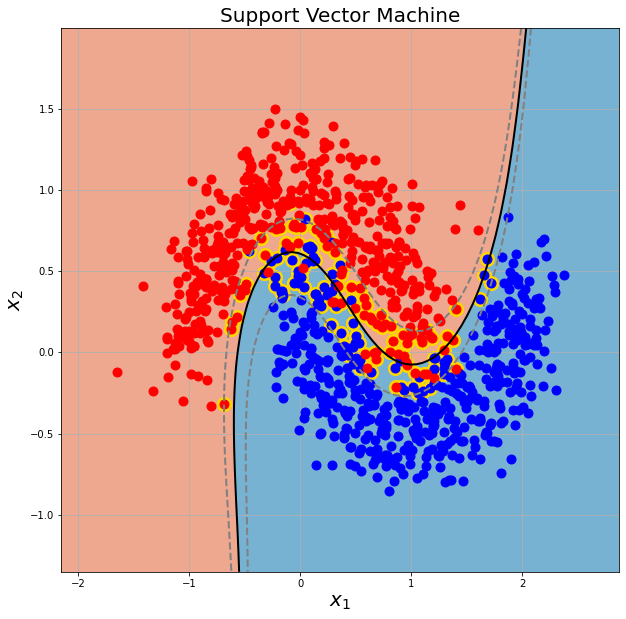

In [2]:
from sklearn.datasets import make_moons
from plotting import *

x, y = make_moons(1000, noise=0.2)
print(y)
y = np.asanyarray(y, dtype=np.float64)
y += (y == 0) * -1.0

model = SVM(kernel='polynomial', C=0.5)
model.fit(x, y)
plot_svm(x, y, model)